# Hotel-Sentiment-Analysis-Two

# Imports

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline as imbPipeline

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, accuracy_score, make_scorer, confusion_matrix

# Functions

In [64]:
def check_null_dupes(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of dupes: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.legend(unique)
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def plot_model_performance(df,y, axis):
  fig, ax = plt.subplots(figsize=(15,8))
  df.plot.bar(x="Model", y=y, ax=ax)
  ax.set_xlabel("Models")
  ax.set_ylabel(axis)
  ax.grid(True)
  plt.xticks(rotation=45)
  plt.show()

def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  filtered_word_tokens = re.sub(r"[^a-zA-Z\s]", "", word_tokens).split()
  filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

def create_sampling_pipeline(sampling_model, model, kbest=None):
  
  steps = [
    ("sample", sampling_model),
    ("model", model)
  ]
  if kbest is not None:
    steps.insert(1, ("kbest", kbest))
  
  return imbPipeline(steps=steps)


def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=2000),
    "SVC": SVC(),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in model_names]

def grab_selected_sampling_models(model_names):
  models = {
    "SMOTE":SMOTE(),
    "BL-SMOTE":BorderlineSMOTE(),
    "KNN": SMOTE(k_neighbors=5),
    "ADASYN": ADASYN()
  }
  
  return [models[model_name] for model_name in model_names]

def create_train_test_splits(X, y):
  
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
  
  return X_train, X_val, X_test, y_train, y_val, y_test

def evaluate_model(X, y , model, scoring_metric=None):
  
  cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=1)
  scoring_metric = make_scorer(f1_score) if not scoring_metric else scoring_metric
  scores = cross_val_score(model, X, y, scoring=scoring_metric, cv=cv, n_jobs=-1)
  mean, var, std = round(np.mean(scores),3), round(np.var(scores),3), round(np.std(scores),3)
  return mean, var, std

def tested_selected_models(model_names, models, X, y):
  
  model_performance = []
  
  for model, model_name in zip(models, model_names):
    mean, var, std = evaluate_model(X, y, model)
    model_performance.append({
      "Model":model_name,
      "Mean": mean,
      "VAR":var,
      "STD": std
    })
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(model_performance_df, ["Mean", "STD", "VAR"], "Mean")
  print(model_performance_df)

def test_sampling_models(sampling_model_names, sampling_models, model_names, models, X, y, metric=None):
  
  model_performance = []
  
  for sample_model_name, sample_model in zip(sampling_model_names, sampling_models):
    for model_name, model in zip(model_names, models):
      pipeline = create_sampling_pipeline(sample_model, model)
      mean, var, std = evaluate_model(X, y, pipeline, metric)
      
      model_performance.append({
      "Model":model_name + "-" + sample_model_name,
      "Mean": mean,
      "VAR":var,
      "STD": std,
    })
  
  performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(performance_df,["Mean", "STD", "VAR"], "Mean")
  print(performance_df)
    
    

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/hotel.csv")
df

,Unnamed: 0,content,translated_content,priority_score,problem_domain
0,1,"Sorry, including the expensive price + apk usi...","Sorry, including the expensive price + apk usi...",2,0
1,2,Setelah install terus pas buka aplikasi ngebla...,"After installed, the app stuck with white display",3,1
2,3,"gak bisa submit pada saat verifikasi data, pad...","Cannot submit the data verification, even my i...",3,1
3,4,Aplilasi restart mulu,The app keep restarting,3,1
4,5,"udah mahal , makanan ga enak, banyak lalat","Overpriced, bad food, too many flies",2,0
...,...,...,...,...,...
695,696,Mohon yang bersihin kamar mandi laki2 khusus l...,Please clean the men's bathrooms specifically ...,2,0
696,697,Kurang kedap suara. Kebangun gara2 pod sebelah...,Loading...,2,0
697,698,Would be nice if people could leave luggage af...,Would be nice if people could leave luggage af...,2,0
698,699,Matrasnya ternyata keras bgt\nDiluar itu so fa...,The mattress turned out to be really hard\nApa...,2,0


# Check for Nulls And Dupes

In [4]:
check_null_dupes(df)

The amount of Nulls: Unnamed: 0            0
content               0
translated_content    0
priority_score        0
problem_domain        0
dtype: int64
The amount of dupes: 0


# Check For Class Imbalance

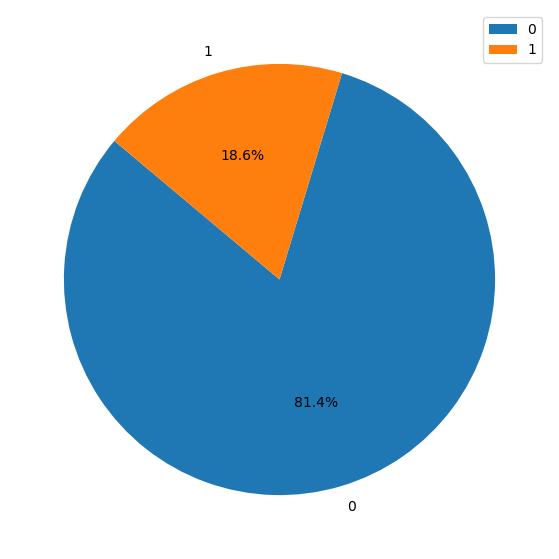

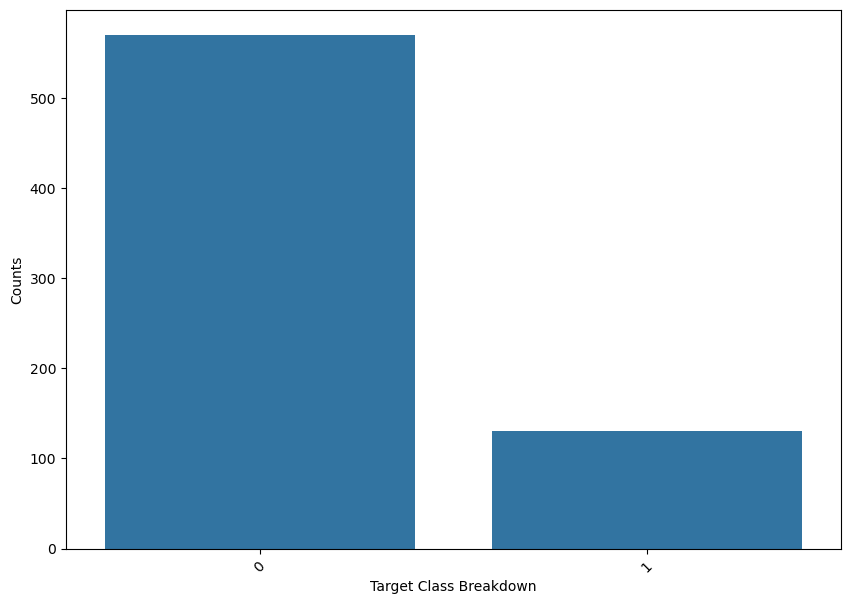

In [6]:
check_class_imbalance(df["problem_domain"])

# Class Imbalance

In [12]:
df["problem_domain"].skew()

1.6198535714195923

# Drop uneeded columns

In [11]:
df.drop(["Unnamed: 0", "content"], axis=1, inplace=True)

In [13]:
df["len_review"] = df["translated_content"].apply(lambda x: len(x))
df["len_wordcount"] = df["translated_content"].apply(lambda x: len(x.split()))

In [14]:
df.describe()

,priority_score,problem_domain,len_review,len_wordcount
count,700.000000,700.000000,700.000000,700.000000
mean,2.184286,0.185714,85.847143,15.421429
std,0.757629,0.389154,144.241753,26.676805
min,1.000000,0.000000,2.000000,1.000000
25%,2.000000,0.000000,10.000000,1.000000
50%,2.000000,0.000000,27.000000,5.000000
75%,3.000000,0.000000,100.500000,19.000000
max,3.000000,1.000000,1381.000000,260.000000


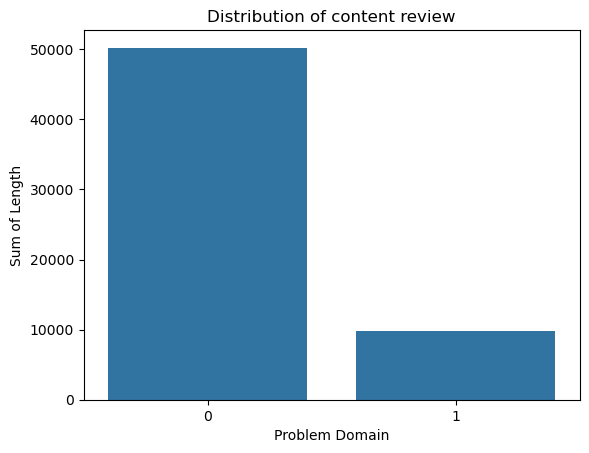

In [15]:
grouped_df = df.groupby("problem_domain")["len_review"].sum().reset_index()

sns.barplot(data=grouped_df, x='problem_domain', y="len_review")
plt.title("Distribution of content review")
plt.xlabel("Problem Domain")
plt.ylabel("Sum of Length")
plt.yscale("linear")
plt.show()

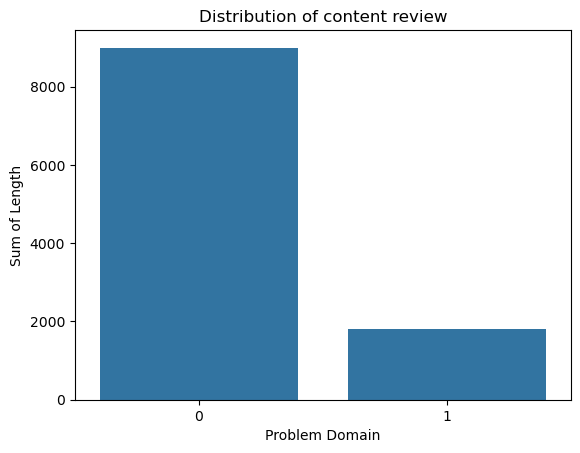

In [16]:
grouped_df = df.groupby("problem_domain")["len_wordcount"].sum().reset_index()

sns.barplot(data=grouped_df, x='problem_domain', y="len_wordcount")
plt.title("Distribution of content review")
plt.xlabel("Problem Domain")
plt.ylabel("Sum of Length")
plt.yscale("linear")
plt.show()

# Data Preprocessing

In [21]:
df["translated_content"] = df["translated_content"].apply(remove_stop_words)

# Separate Feature Variables

In [22]:
X, y = df.drop("problem_domain", axis=1), df["problem_domain"]

# Vectorize Text Data

In [27]:
vectorizer = TfidfVectorizer()
vector_df = pd.DataFrame(vectorizer.fit_transform(X["translated_content"]).toarray())
X.drop("translated_content", axis=1, inplace=True)
vector_df_features = vectorizer.get_feature_names_out()

X = pd.concat([X, vector_df], axis=1)

# Standardize Dataset

In [36]:
steps = [
  ("Scaler", StandardScaler()),
  ("Powertransformer", PowerTransformer())
]
pipeline = Pipeline(steps=steps)
X_processed = pipeline.fit_transform(X)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/utils/validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


# Baseline Model Evaluation

In [38]:
model = DummyClassifier(strategy="constant", constant=1)
mean, var, std  = evaluate_model(X_processed,y, model)

print(f"Mean F1 Score: {mean}, Var: {var}, STD: {std}")

Mean F1 Score: 0.313, Var: 0.0, STD: 0.0


# Advanced model metrics

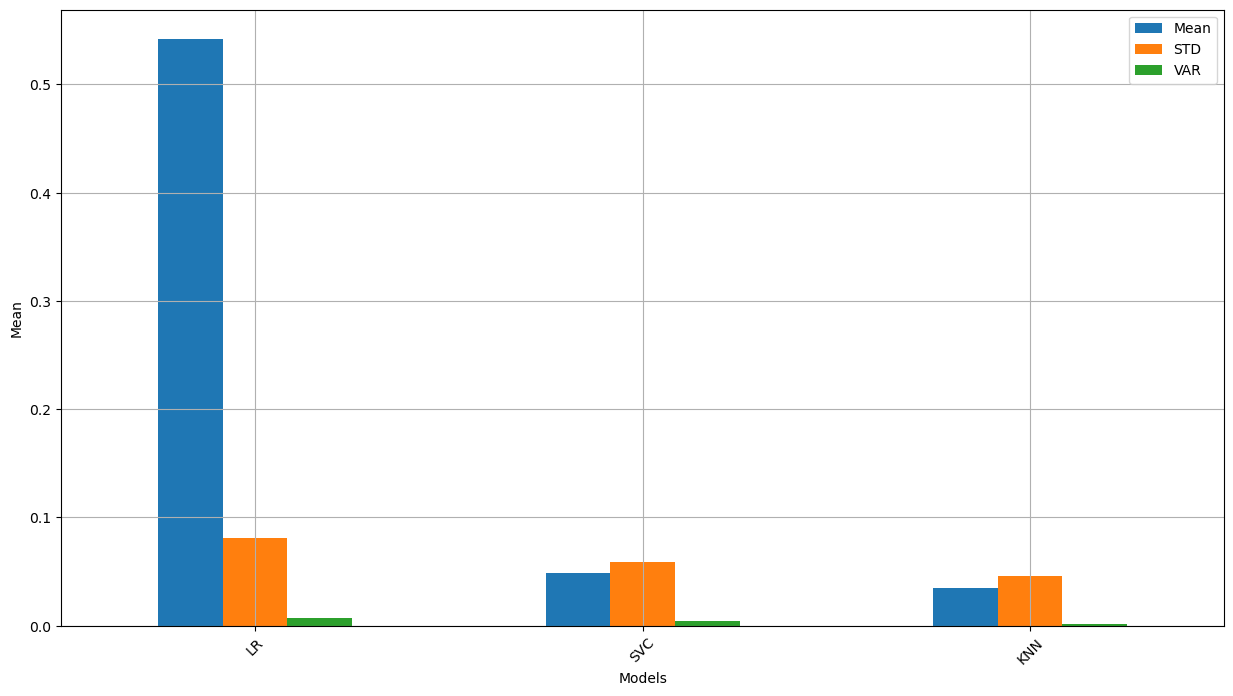

   index Model   Mean    VAR    STD
0      0    LR  0.542  0.007  0.081
1      1   SVC  0.049  0.004  0.059
2      2   KNN  0.035  0.002  0.046


In [44]:
model_names = [
  "LR",
  "SVC",
  "KNN"
]
models = grab_selected_models(model_names)

tested_selected_models(model_names, models, X_processed, y)

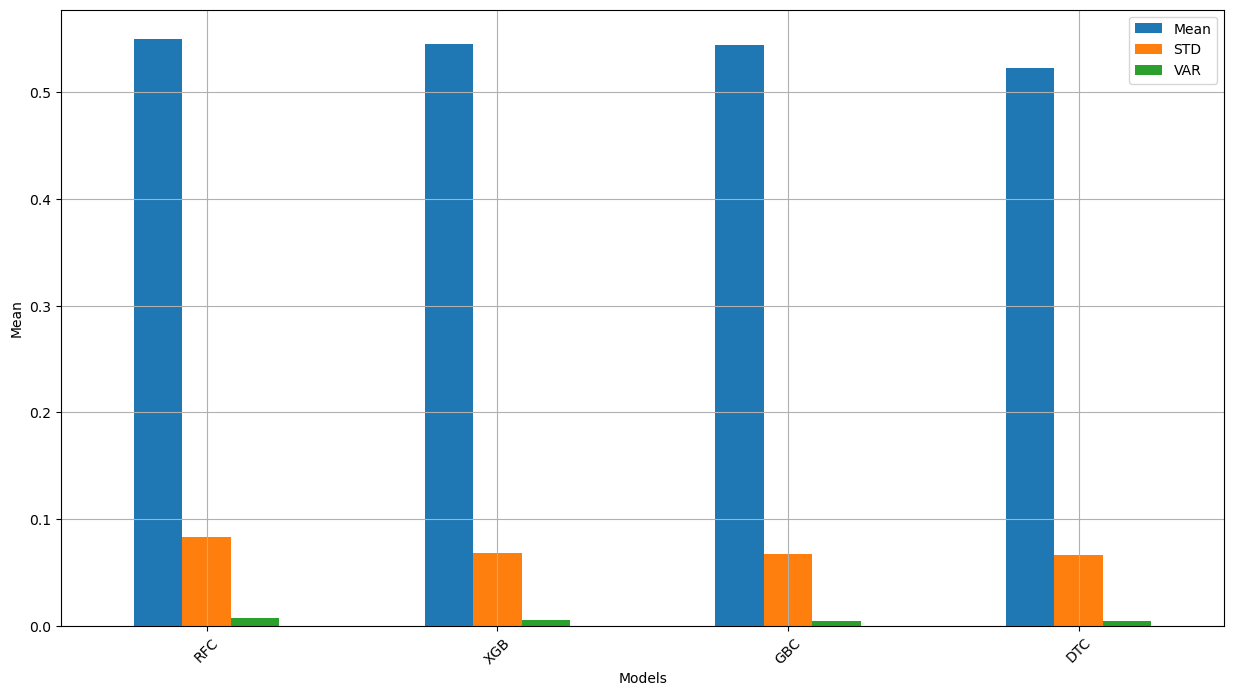

   index Model   Mean    VAR    STD
0      0   RFC  0.550  0.007  0.083
1      2   XGB  0.545  0.005  0.068
2      1   GBC  0.544  0.004  0.067
3      3   DTC  0.523  0.004  0.066


In [45]:
model_names =[
  "RFC",
  "GBC",
  "XGB",
  "DTC"
]
models = grab_selected_models(model_names)
tested_selected_models(model_names, models, X_processed, y)

# Measuring the models performance using the f1 score shows that the class is imbalanced and is performing poorly. Let's address this with some over sampling methods.

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: U

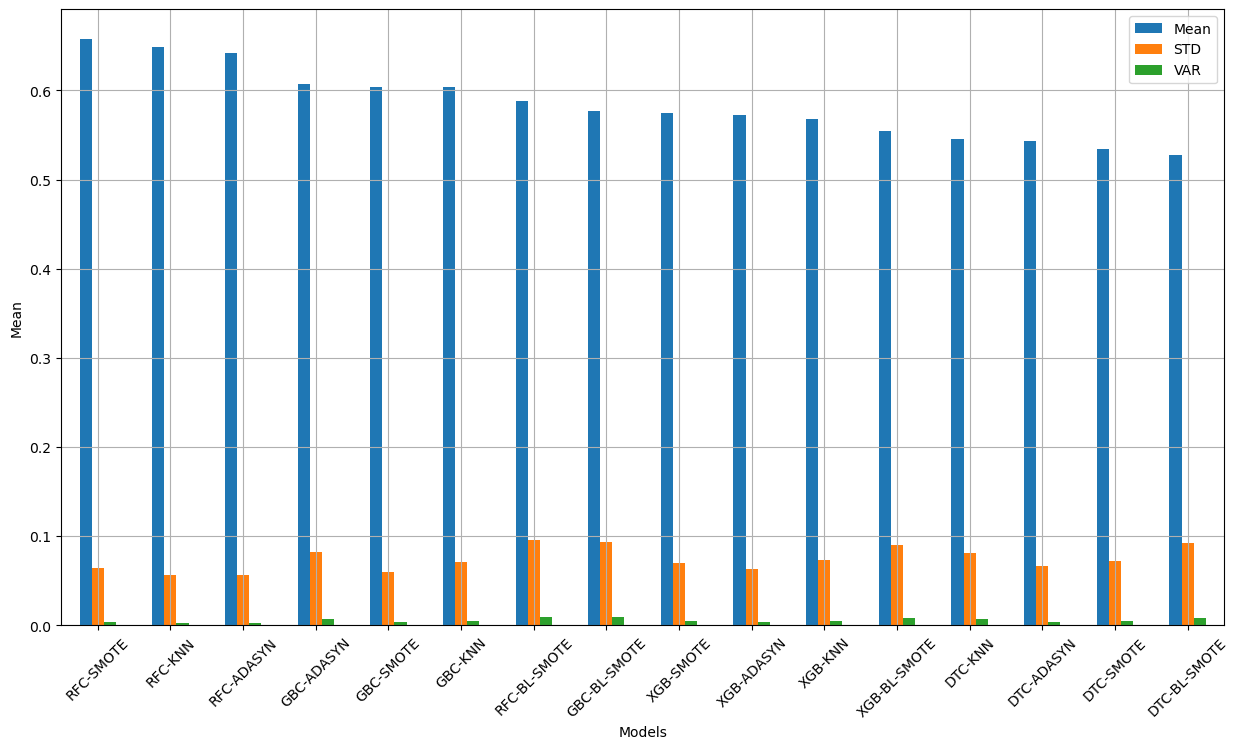

    index         Model   Mean    VAR    STD
0       0     RFC-SMOTE  0.658  0.004  0.064
1       8       RFC-KNN  0.649  0.003  0.057
2      12    RFC-ADASYN  0.642  0.003  0.057
3      13    GBC-ADASYN  0.607  0.007  0.082
4       1     GBC-SMOTE  0.604  0.004  0.060
5       9       GBC-KNN  0.604  0.005  0.071
6       4  RFC-BL-SMOTE  0.588  0.009  0.096
7       5  GBC-BL-SMOTE  0.577  0.009  0.093
8       2     XGB-SMOTE  0.575  0.005  0.070
9      14    XGB-ADASYN  0.573  0.004  0.063
10     10       XGB-KNN  0.568  0.005  0.073
11      6  XGB-BL-SMOTE  0.554  0.008  0.090
12     11       DTC-KNN  0.546  0.007  0.081
13     15    DTC-ADASYN  0.543  0.004  0.067
14      3     DTC-SMOTE  0.534  0.005  0.072
15      7  DTC-BL-SMOTE  0.528  0.008  0.092


In [59]:
sampling_model_names = [
  "SMOTE",
  "BL-SMOTE",
  "KNN", 
  "ADASYN"
  ]
sampling_models = grab_selected_sampling_models(sampling_model_names)

model_names =[
  "RFC",
  "GBC",
  "XGB",
  "DTC"
]

models = grab_selected_models(model_names)

test_sampling_models(sampling_model_names, sampling_models, model_names, models, X_processed, y)

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


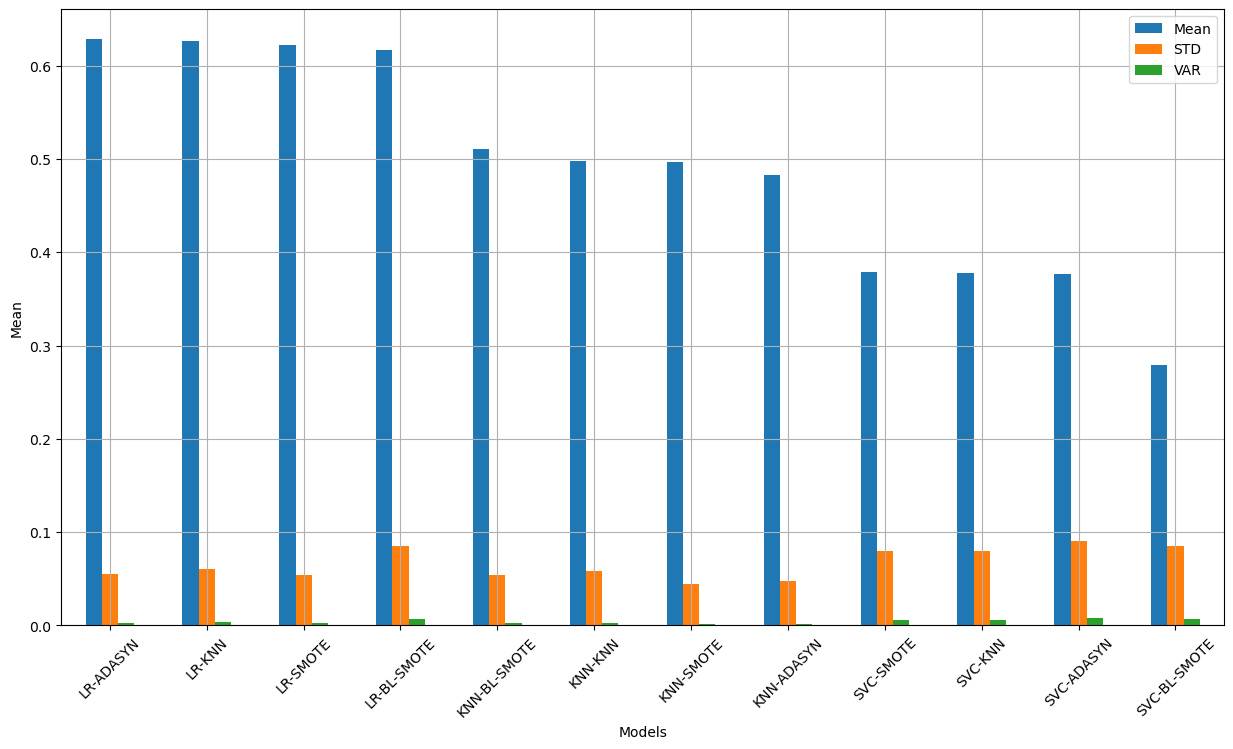

    index         Model   Mean    VAR    STD
0       9     LR-ADASYN  0.629  0.003  0.055
1       6        LR-KNN  0.627  0.004  0.060
2       0      LR-SMOTE  0.622  0.003  0.054
3       3   LR-BL-SMOTE  0.617  0.007  0.085
4       5  KNN-BL-SMOTE  0.511  0.003  0.054
5       8       KNN-KNN  0.498  0.003  0.058
6       2     KNN-SMOTE  0.497  0.002  0.044
7      11    KNN-ADASYN  0.483  0.002  0.048
8       1     SVC-SMOTE  0.379  0.006  0.080
9       7       SVC-KNN  0.378  0.006  0.080
10     10    SVC-ADASYN  0.377  0.008  0.090
11      4  SVC-BL-SMOTE  0.279  0.007  0.085


In [60]:
model_names =[
  "LR",
  "SVC",
  "KNN"
]

models = grab_selected_models(model_names)

test_sampling_models(sampling_model_names, sampling_models, model_names, models, X_processed, y)

# The model is performing poorly due to our scoring metric which gives equal weight to both target classes, if we switched to accuracy score as a metric instead of an f1 score, our model performance would increase dramatically, lets test this theory out.

In [65]:
model_names =[
  "RFC",
  "GBC",
  "XGB",
  "DTC"
]

models = grab_selected_models(model_names)
scoring_metric= make_scorer(accuracy_score)

test_sampling_models(sampling_model_names, sampling_models, model_names, models, X_processed, y, metric=scoring_metric)